<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:

In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

C:\Users\ASENPRINCE\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# notice: Disable all warnings
import warnings
warnings.filterwarnings('ignore')

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


### Loading the train dataset

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

## Data Wrangling

### Convert date time object

In [6]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

In [7]:
# from the dtypes, effective dates and due_dates are objects, converting it to datetime

df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

print(df.dtypes)

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object


## Data Visualization and pre-processing

checking how many each class is in our dataset

In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:

In [9]:
# notice: import seaborn
import seaborn as sns

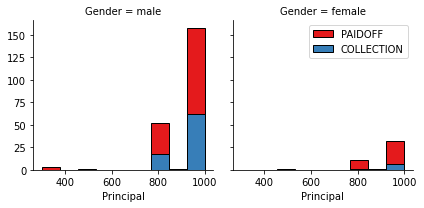

In [10]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col='Gender', hue='loan_status', palette='Set1', col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec='k')

g.axes[-1].legend()
plt.show()

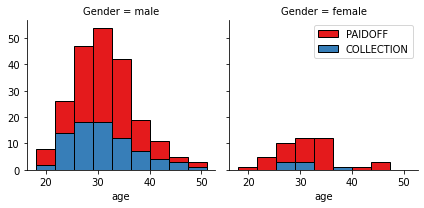

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col='Gender', hue='loan_status', palette='Set1', col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec='k')

g.axes[-1].legend()
plt.show()

## Pre-processing: Feature selection/extraction

### Let's look at the day of the week people get the loan

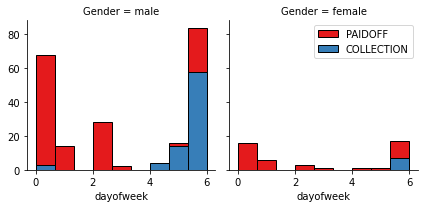

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g=sns.FacetGrid(df, col='Gender', hue='loan_status', palette='Set1', col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4

In [13]:
df['weekend'] = df.dayofweek.apply(lambda x: 1 if (x>3) else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Let's look at gender

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

let's convert male to 0 and female to 1

In [15]:
df.Gender.replace(to_replace=['male', 'female'], value=[0,1], inplace=True)
df.Gender.head()

0    0
1    1
2    0
3    1
4    0
Name: Gender, dtype: int64

## One Hot Encoding

#### How about education?

In [16]:
df.education.head()

0    High School or Below
1                Bechalor
2                 college
3                 college
4                 college
Name: education, dtype: object

In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [18]:
pd.get_dummies(df.education)

,Bechalor,High School or Below,Master or Above,college
0,0,1,0,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
341,0,1,0,0
342,0,1,0,0
343,0,0,0,1
344,0,0,0,1


#### Features before One Hot Encoding

In [19]:
df[['Principal', 'terms', 'age', 'Gender', 'weekend']]

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1
...,...,...,...,...,...
341,800,15,32,0,1
342,1000,30,25,0,1
343,800,15,39,0,0
344,1000,30,28,0,0


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame

In [20]:
Feature = df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
Feature = pd.concat([Feature, pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis=1, inplace=True)
Feature.head()

# dropped Master or Above because 50% chance of either PAIDOFF OR COLLECTION.
# not a good determinant

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection

Let's define the feature set, X:

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data

Data Standardization give data zero mean and unit variance (technically should be done after train test split)

In [23]:
X = preprocessing.StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


#### Train_test split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)
print('Train size: ',X_train.shape[0], y_train.shape[0])
print('Test size: ',X_test.shape[0], y_test.shape[0])

Train size:  311 311
Test size:  35 35


### defs for optimized evaluation metrics

In [26]:
#def optEvaluationMetrics(model):
    

In [27]:
mean_acc=np.zeros((2,9))
mean_acc

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.

In [61]:
from sklearn.neighbors import KNeighborsClassifier as kc
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

In [75]:
def best_Kvalue(X_train_dataset,X_test_dataset, y_train_dataset, y_test_dataset, ks=10):
    scores = np.zeros((ks-1))
    
    for n in range(1,ks):
        # Train the model
        neigh = kc(n_neighbors=n).fit(X_train_dataset,y_train_dataset)
        #Predict
        yhat=neigh.predict(X_test_dataset)
        # Calculate the accuracy score
        scores[n-1] = accuracy_score(y_test_dataset, yhat)
        #print(n-1)
    
    return (scores)



In [76]:
ks= 25
accuracy_list = best_Kvalue(X_train, X_test, y_train, y_test, ks)
#accuracy_list
best_k = accuracy_list.argmax()+1
best_score = max(accuracy_list)
best_k, best_score

(18, 0.9142857142857143)

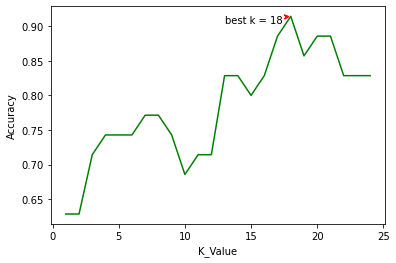

In [77]:
# Visualization
plt.plot(range(1, ks), accuracy_list, 'g')
plt.annotate('best k = '+ str(accuracy_list.argmax()+1),
             xy=(accuracy_list.argmax()+1, max(accuracy_list)),
             xytext=(accuracy_list.argmax()-4, max(accuracy_list)-0.01),
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', color='red'))

plt.xlabel('K_Value')
plt.ylabel('Accuracy')
plt.show()

# Decision Tree

In [32]:
# import the relevant package
from sklearn.tree import DecisionTreeClassifier as dtc
import array as arr

In [33]:
# funtion to choose best criterion and max_depth value
def best_tree_parameters(X_trainset, X_testset, y_trainset, y_testset, max_depth=8):
    criteria = ['gini', 'entropy']
    scores = np.zeros((max_depth-1, len(criteria)))
    depths = []
    for depth in range(1, max_depth):
        for criterion in criteria:
            # develop model using train set
            train_tree = dtc(criterion=criterion, max_depth=depth).fit(X_trainset, y_trainset)
            # predict model
            predTree = train_tree.predict(X_testset)
            # Evaluate the model
            index = 0 if criterion is 'gini' else 1
            scores[depth-1][index]=np.asanyarray(accuracy_score(predTree, y_testset))
    return (scores)
            

In [34]:
max_depth=15
scores_ist = best_tree_parameters(X_train, X_test, y_train, y_test, max_depth)


In [36]:
pdf = pd.DataFrame(scores_ist)
pdf.columns=("gini", "entropy")
pdf['Depth'] = range(1, max_depth)
pdf.index=pdf.Depth
pdf.drop('Depth', axis=1, inplace=True)
pdf

,gini,entropy
Depth,,
1,0.828571,0.828571
2,0.828571,0.828571
3,0.828571,0.828571
4,0.771429,0.828571
5,0.742857,0.771429
6,0.742857,0.742857
7,0.657143,0.742857
8,0.628571,0.657143
9,0.628571,0.628571


<AxesSubplot:xlabel='Depth'>

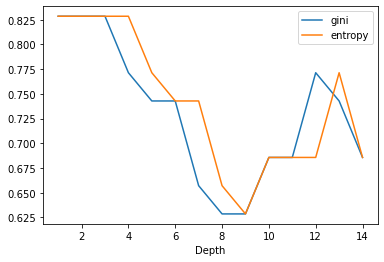

In [37]:
# Visualize the scores
pdf.plot(kind='line')

For max_depth 4, the best criterion is `entropy`. `max_depth` 1-3 have the best scores for both criteria

# Support Vector Machine

In [53]:
from sklearn import svm

### Function for the best kernel

In [119]:
def svm_kernels(X_train, X_test, y_train, y_test):
    
    kernels = {'rbf':0, 'linear':1, 'poly':2, 'sigmoid':3}
    svm_scores_dict = {}
    
    for kernel, index in kernels.items():
        # Develop model with kernel
        svm_model = svm.SVC(kernel=kernel).fit(X_train, y_train)
        # Predict with the developed model with test feature
        yhat = svm_model.predict(X_test)
        # Evaluate with accuracy score
        svm_scores_dict[kernel] = format(accuracy_score(yhat, y_test), '.2f')
    return svm_scores_dict

In [120]:
# Testing the function
svm_ = svm_kernels(X_train, X_test, y_train, y_test)
svm_

{'rbf': '0.77', 'linear': '0.83', 'poly': '0.83', 'sigmoid': '0.77'}

In [121]:
df = pd.DataFrame(columns={'kernel', 'score'})
df['kernel']=svm_.keys()
df['score']=svm_.values()
df.score=df.score.astype('float')
df

,kernel,score
0,rbf,0.77
1,linear,0.83
2,poly,0.83
3,sigmoid,0.77


#### Comments
Best kernel for the svm is either `linear` or `poly`

# Logistic Regression


In [122]:
from sklearn.linear_model import LogisticRegression

In [123]:
# Function for best solver and regularized value combo
def best_log_params(X_trainset, X_testset, y_trainset, y_testset):
    ''' 
    params: train and test dataset
    returns: best parameters for the logistic model based on accuracy score
    '''
    # Initialization of variabels to be used
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    regValues = np.arange(0.01, 1, 0.1)
    best_score = 0 # initialization of the best score to 0
    param_dict = {} # to store dictionary for the best parameters
    # scoreList = [] # list to keep the scores, for reference on whether the output is correct
    
    for solver in solvers:
        for regVal in regValues:
            # develop model using the parameters
            LogReg = LogisticRegression(C=regVal, solver=solver).fit(X_trainset, y_trainset)
            # predict model using test set of the Feature
            yhat = LogReg.predict(X_testset)
            # Evaluate the score
            score = accuracy_score(yhat, y_testset)
            # scoreList.append((score, solver, regVal))
            if score > best_score:
                best_score=score
                param_dict['solver'], param_dict['optimal regVal'], param_dict['best_score'] = solver, regVal, score
    return param_dict

In [124]:
# Test the function with the dataset
logOptimalParams = best_log_params(X_train, X_test, y_train, y_test)
logOptimalParams

{'solver': 'newton-cg',
 'optimal regVal': 0.01,
 'best_score': 0.8285714285714286}

### Comments
the score for the model is the same irrespective of the `solver` or `C`. The score for the logistic model is `~83%`

# Model Evaluation using Test set

In [128]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [126]:
df_test.shape

(54, 10)

In [127]:
# import relevant packages for the evaluation
from sklearn.metrics import jaccard_score, f1_score, log_loss

## Data Wrangling

In [129]:
test_df.due_date = pd.to_datetime(test_df.due_date)
test_df.effective_date = pd.to_datetime(test_df.effective_date)

In [130]:
test_df['dayofweek']=test_df.effective_date.dt.dayofweek
test_df['weekend']=test_df.dayofweek.apply(lambda x: 1 if (x>3) else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [131]:
# convert categorical to numerical
test_df.Gender.replace(to_replace=['male', 'female'], value=[0,1], inplace=True)

# One hot encoding and defining the Feature_test set
test_Feature = test_df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
test_Feature.head()

,Principal,terms,age,Gender,weekend
0,1000,30,50,1,0
1,300,7,35,0,1
2,1000,30,43,1,1
3,1000,30,26,0,1
4,800,15,29,0,1


In [132]:
# concatenate test_Feature with the one hot encoding of education
test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df.education)], axis=1)
test_Feature.drop(['Master or Above'], axis=1, inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [133]:
# define y value
yTest = test_df['loan_status']

In [134]:
# KNN = best_Kvalue - define ks
# DecisionTree = best_tree_parameters - define max_depth
# SVM = svm_kernels
# Logistic Regression = best_log_params

# Initializing the dataset that would be utilized
data = (Feature, test_Feature, y, yTest)
train_set = (Feature, y) 
evaluation_dict = {} # dictionary to store the scores

In [135]:
# KNN best k neighbor
ks=100
knn_param = best_Kvalue(*data, ks)
best_k = knn_param.argmax()+1
best_score = max(knn_param)
best_k, best_score

(8, 0.7592592592592593)

In [136]:
# Develop Model
from sklearn.neighbors import KNeighborsClassifier as kc
knn_model = kc(n_neighbors=best_k).fit(*train_set)

# Predict with testset
knn_predict = knn_model.predict(test_Feature)

# Evaluation - jaccard_score and f1_score
from sklearn.metrics import jaccard_score, f1_score
knn_jaccard = format(jaccard_score(knn_predict, yTest, pos_label='COLLECTION'), '.2f')
knn_f1 = format(f1_score(knn_predict, yTest, average='weighted'), '.2f')

evaluation_dict['KNN'] = knn_jaccard, knn_f1, 'NA'
evaluation_dict

{'KNN': ('0.07', '0.85', 'NA')}

In [137]:
# Decision tree best params
btp = best_tree_parameters(*data, 15)
pdf = pd.DataFrame(btp)
pdf.columns=("gini", "entropy")
pdf['Depth'] = range(1, max_depth)
pdf.index=pdf.Depth
pdf.drop('Depth', axis=1, inplace=True)

<AxesSubplot:xlabel='Depth'>

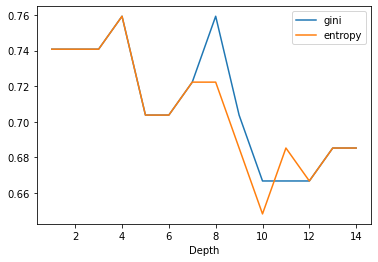

In [138]:
pdf.plot(kind='line')

params: `entropy` or `gini` with `max_depth` of `4`

In [139]:
# Develop Model
from sklearn.tree import DecisionTreeClassifier as DTC
tree_model = DTC(criterion='entropy', max_depth=4).fit(*train_set)

# Predict with testset
tree_predict = tree_model.predict(test_Feature)

# Evaluation - jaccard_score and f1_score
from sklearn.metrics import jaccard_score, f1_score
tree_jaccard = format(jaccard_score(tree_predict, yTest, pos_label='COLLECTION'), '.2f')
tree_f1 = format(f1_score(tree_predict, yTest, average='weighted'), '.2f')

evaluation_dict['Decision Tree'] = tree_jaccard, tree_f1, 'NA'
evaluation_dict

{'KNN': ('0.07', '0.85', 'NA'), 'Decision Tree': ('0.13', '0.82', 'NA')}

In [140]:
## SVM
svm_k = svm_kernels(*data)
svm_k

{'rbf': '0.74', 'linear': '0.74', 'poly': '0.74', 'sigmoid': '0.74'}

any kernel would be suitable

In [141]:
# Develop Model
from sklearn import svm
svm_model = svm.SVC().fit(*train_set)

# Predict with testset
svm_predict = svm_model.predict(test_Feature)

# Evaluation - jaccard_score and f1_score
from sklearn.metrics import jaccard_score, f1_score
svm_jaccard = format(jaccard_score(svm_predict, yTest, pos_label='COLLECTION'), '.2f')
svm_f1 = format(f1_score(svm_predict, yTest, average='weighted'), '.2f')

evaluation_dict['SVM'] = svm_jaccard, svm_f1, 'NA'
evaluation_dict

{'KNN': ('0.07', '0.85', 'NA'),
 'Decision Tree': ('0.13', '0.82', 'NA'),
 'SVM': ('0.00', '0.85', 'NA')}

In [142]:
### logReg
logReg = best_log_params(*data)
logReg

{'solver': 'newton-cg',
 'optimal regVal': 0.81,
 'best_score': 0.7592592592592593}

In [143]:
# Develop Model
from sklearn.linear_model import LogisticRegression
logReg_model = LogisticRegression(solver=logReg['solver'], C=logReg['optimal regVal']).fit(*train_set)

# Predict with testset
logReg_predict = logReg_model.predict(test_Feature)
logReg_predict_prob = logReg_model.predict_proba(test_Feature)

# Evaluation - jaccard_score and f1_score
from sklearn.metrics import jaccard_score, f1_score
logReg_jaccard = format(jaccard_score(logReg_predict, yTest, pos_label='COLLECTION'), '.2f')
logReg_f1 = format(f1_score(logReg_predict, yTest, average='weighted'), '.2f')
logLoss = format(log_loss(yTest, logReg_predict_prob), '.2f')

evaluation_dict['LogisticRegression'] = logReg_jaccard, logReg_f1, logLoss
evaluation_dict

{'KNN': ('0.07', '0.85', 'NA'),
 'Decision Tree': ('0.13', '0.82', 'NA'),
 'SVM': ('0.00', '0.85', 'NA'),
 'LogisticRegression': ('0.07', '0.85', '0.47')}

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [146]:
# Generating the report using pandas dataframe
ev_df = pd.DataFrame(columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'])

for key, values in evaluation_dict.items():
    algo = key
    jacc = values[0]
    f1s = values[1]
    logloss = values[2]
    
    ev_df = ev_df.append([{'Algorithm': algo, 'Jaccard': jacc, 'F1-score': f1s, 'LogLoss': logloss}])

ev_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.07,0.85,NA
0,Decision Tree,0.13,0.82,NA
0,SVM,0.00,0.85,NA
0,LogisticRegression,0.07,0.85,0.47
